In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import builtins

# def print(*args, **kwargs):
#     kwargs["sep"] = ""
#     return builtins.print(*args, **kwargs)


plt.rcParams["figure.figsize"] = (6, 4)
# Change to stix
plt.rcParams["font.family"] = "STIXGeneral"

import warnings
warnings.filterwarnings("ignore")

### Lab Task 1

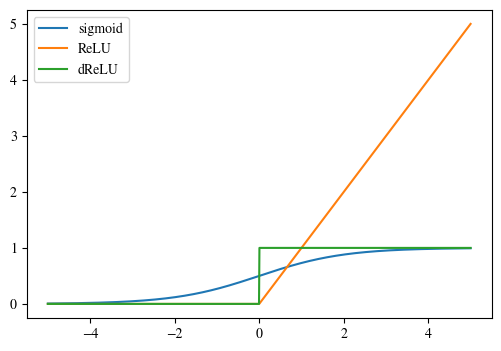

In [3]:
"""
Write the code for the following activation functions:

- sigmoid
- ReLU
- dReLU

Call each function with any value for z and take screenshots of your work. Provide the code and all relevant screenshots.
"""

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def drelu(z):
    return np.where(z > 0, 1, 0)

z = np.linspace(-5, 5, 1000)
plt.plot(z, sigmoid(z), label="sigmoid")
plt.plot(z, relu(z), label="ReLU")
plt.plot(z, drelu(z), label="dReLU")
plt.legend()
plt.show()

### Dataset

In [4]:
"""
Download a dataset containing 3 feature columns and 1 label column with binary values. You will design and train a neural network on the dataset to predict the y values.
"""

df = pd.read_csv("diabetes.csv")
features = ["DiabetesPedigreeFunction", "BMI", "BloodPressure"]
df.dropna(inplace=True)
X = df[features].values
y = df["Outcome"].values

def feature_scaling(X, axis=0):
    return (X - X.min(axis=axis)) / (X.max(axis=axis) - X.min(axis=axis))

# Split the dataset into training and test datasets
def random_split(X, y, ratio=0.8, scaling=feature_scaling):
    m = len(X)
    X = np.random.permutation(X)
    split = int(m * ratio)
    return (
        feature_scaling(X[:split]),
        y[:split].reshape(1, -1),
        feature_scaling(X[split:]),
        y[split:].reshape(1, -1),
    )

X_train, y_train, X_test, y_test = random_split(X, y)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (614, 3)
y_train shape:  (1, 614)
X_test shape:  (154, 3)
y_test shape:  (1, 154)


### Lab Task 2

In [5]:
layers = [3, 5, 5, 1]

# Initialize W and b
parameters = {}
for i in range(1, len(layers)):
    parameters["W" + str(i)] = np.random.normal(
        0, layers[i - 1] ** -0.5, (layers[i], layers[i - 1])
    )
    parameters["B" + str(i)] = np.random.randn(layers[i], 1)

print("Shape of W and b:")
for key, value in parameters.items():
    print(key, value.shape)

# Initialize Z and A
Z = {}
A = {}
for i in range(1, len(layers)):
    Z["Z" + str(i)] = np.zeros((layers[i], 1))
    A["A" + str(i)] = np.zeros((layers[i], 1))

print("\nShape of Z and A:")
for (kZ, kV), (kA, vA) in zip(Z.items(), A.items()):
    print(kZ, kV.shape, "|", kA, vA.shape)

# Initialize dZ, dZcache, dW, dB
dZ = {}
dZcache = {}
dW = {}
dB = {}

for i in range(1, len(layers)):
    dZ["dZ" + str(i)] = np.zeros((layers[i], 1))
    dZcache["dZ" + str(i)] = np.zeros((layers[i], 1))
    dW["dW" + str(i)] = np.zeros((layers[i], layers[i - 1]))
    dB["dB" + str(i)] = np.zeros((layers[i], 1))

print("\nShape of dZ and dZcache:")
for (kZ, kV), (kA, vA) in zip(dZ.items(), dZcache.items()):
    print(kZ, kV.shape, "|", kA, vA.shape)

print("\nShape of dW and dB:")
for (kZ, kV), (kA, vA) in zip(dZ.items(), dZcache.items()):
    print(kZ, kV.shape, "|", kA, vA.shape)


def initialize_parameters(layers):
    parameters = {}
    for i in range(1, len(layers)):
        parameters["W" + str(i)] = np.random.normal(
            0, layers[i - 1] ** -0.5, (layers[i], layers[i - 1])
        )
        parameters["B" + str(i)] = np.random.randn(layers[i], 1)
    return parameters


def initialize_dicts(layers):
    Z = {}
    A = {}
    dZ = {}
    dZcache = {}
    dW = {}
    dB = {}
    for i in range(1, len(layers)):
        Z["Z" + str(i)] = np.zeros((layers[i], 1))
        A["A" + str(i)] = np.zeros((layers[i], 1))
        dZ["dZ" + str(i)] = np.zeros((layers[i], 1))
        dZcache["dZ" + str(i)] = np.zeros((layers[i], 1))
        dW["dW" + str(i)] = np.zeros((layers[i], layers[i - 1]))
        dB["dB" + str(i)] = np.zeros((layers[i], 1))
    return Z, A, dZ, dZcache, dW, dB

parameters = initialize_parameters(layers)
Z, A, dZ, dZcache, dW, dB = initialize_dicts(layers)

Shape of W and b:
W1 (5, 3)
B1 (5, 1)
W2 (5, 5)
B2 (5, 1)
W3 (1, 5)
B3 (1, 1)

Shape of Z and A:
Z1 (5, 1) | A1 (5, 1)
Z2 (5, 1) | A2 (5, 1)
Z3 (1, 1) | A3 (1, 1)

Shape of dZ and dZcache:
dZ1 (5, 1) | dZ1 (5, 1)
dZ2 (5, 1) | dZ2 (5, 1)
dZ3 (1, 1) | dZ3 (1, 1)

Shape of dW and dB:
dZ1 (5, 1) | dZ1 (5, 1)
dZ2 (5, 1) | dZ2 (5, 1)
dZ3 (1, 1) | dZ3 (1, 1)


### Lab Task 3

In [6]:
"""
Write the code for implementing forward propagation given as follows:

Z1 = W1X + B1		A1 = ReLU(Z1)
Z2 = W2A1 + B2		A2 = ReLU(Z2)
Z3 = W3A2 + B3		A3 = Sigmoid(Z3)

Ensure that your forward propagation function works on both training and test datasets. Run your code on both the training and test datasets to give out their respective costs. Provide the code and all relevant screenshots of the final output.
"""

def forward_propagation(X, parameters, Z, A):
    Z["Z1"] = np.dot(parameters["W1"], X.T) + parameters["B1"]
    A["A1"] = relu(Z["Z1"])
    Z["Z2"] = np.dot(parameters["W2"], A["A1"]) + parameters["B2"]
    A["A2"] = relu(Z["Z2"])
    Z["Z3"] = np.dot(parameters["W3"], A["A2"]) + parameters["B3"]
    A["A3"] = sigmoid(Z["Z3"])
    
    return A["A3"]


print("Forward propagation on test dataset:")
y_pred = forward_propagation(X_test, parameters, Z, A)
print(y_pred.shape)

print("\nForward propagation on training dataset:")
y_pred = forward_propagation(X_train, parameters, Z, A)
print(y_pred.shape)

Forward propagation on test dataset:
(1, 154)

Forward propagation on training dataset:
(1, 614)


### Lab Task 4

In [7]:
"""
Write the code for implementing backward propagation given in the manual.
"""


def backward_propagation(X, y, parameters, Z, A, dZcache, dW, dB):
    m = X.shape[0]

    dZcache["dZ3"] = A["A3"] - y
    dW["dW3"] = np.dot(dZcache["dZ3"], A["A2"].T) / m
    dB["dB3"] = np.sum(dZcache["dZ3"], axis=1, keepdims=True) / m

    dZcache["dZ2"] = np.dot(parameters["W3"].T, dZcache["dZ3"]) * drelu(Z["Z2"])
    dW["dW2"] = np.dot(dZcache["dZ2"], A["A1"].T) / m
    dB["dB2"] = np.sum(dZcache["dZ2"], axis=1, keepdims=True) / m

    dZcache["dZ1"] = np.dot(parameters["W2"].T, dZcache["dZ2"]) * drelu(Z["Z1"])
    dW["dW1"] = np.dot(dZcache["dZ1"], X) / m
    dB["dB1"] = np.sum(dZcache["dZ1"], axis=1, keepdims=True) / m

    return dZcache, dW, dB


def update_parameters(parameters, dW, dB, alpha=0.01):
    for key, value in parameters.items():
        if key.startswith("W"):
            parameters[key] -= alpha * dW["d" + key]
        elif key.startswith("B"):
            parameters[key] -= alpha * dB["d" + key]
        else:
            raise ValueError("Invalid key")
    return parameters


forward_propagation(X_train, parameters, Z, A)
backward_propagation(X_train, y_train, parameters, Z, A, dZcache, dW, dB)
update_parameters(parameters, dW, dB)

np.savez("parameters.npz", **parameters)

### Lab Task 5

Epoch 0 | Train cost: 0.6535339906439919 | Test cost: 0.664708164282188
Epoch 10 | Train cost: 0.6480070679854604 | Test cost: 0.6587517577178205
Epoch 20 | Train cost: 0.6461639409796378 | Test cost: 0.6565022741146921
Epoch 30 | Train cost: 0.6455624528182559 | Test cost: 0.655612592790141
Epoch 40 | Train cost: 0.6453667668011777 | Test cost: 0.655235791421633
Epoch 50 | Train cost: 0.6453009913229529 | Test cost: 0.6550625798301742
Epoch 60 | Train cost: 0.645277164235549 | Test cost: 0.6549775162533689
Epoch 70 | Train cost: 0.645266890721429 | Test cost: 0.6549336578120215
Epoch 80 | Train cost: 0.6452609855530559 | Test cost: 0.6549103637735153
Epoch 90 | Train cost: 0.6452564846846067 | Test cost: 0.6548978527303612


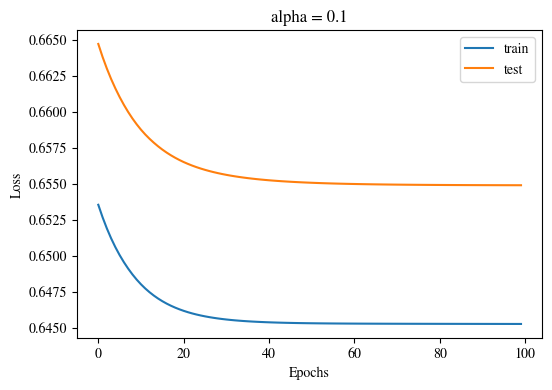

In [8]:
"""
In this task, you will use the functions from the previous tasks to write a “main” function that performs the actual training and testing.

First, forward propagate through the training examples to determine the training cost. Then, back propagate to determine the weight gradients. Next, use the gradients to update the weights. Finally, forward propagate through the test examples to determine the test cost. This single iteration over the entire dataset (both training and test) marks completion of one epoch.

You will need to perform the training and testing over several epochs (the epoch number is another hyperparameter that must be chosen). Ensure that at the end of each epoch, the training and test losses are stored for plotting purposes. When the final epoch is performed, save the trained parameters (weights and bias) and make plot of the training and test losses (y-axis) over the epochs (x-axis). Ensure that both of the losses appear on the same graph. 

Tune the alpha parameter to some other values to obtain more plots. You will need to obtain at least 9 plots. Ensure that the alpha value is mentioned on each plot. Provide the code (excluding function definitions), all relevant screenshots and plots. 
"""

alpha = 0.1
epochs = 100
layers = [3, 5, 5, 1]


def train(X_train, y_train, X_test, y_test, parameters, alpha, epochs, layers):
    parameters = initialize_parameters(layers)
    Z, A, dZ, dZcache, dW, dB = initialize_dicts(layers)

    train_costs = []
    test_costs = []
    for epoch in range(epochs):
        A3_train = forward_propagation(X_train, parameters, Z, A)
        dZcache, dW, dB = backward_propagation(
            X_train, y_train, parameters, Z, A, dZcache, dW, dB
        )
        parameters = update_parameters(parameters, dW, dB, alpha)
        train_cost = -np.mean(
            y_train * np.log(A3_train) + (1 - y_train) * np.log(1 - A3_train)
        )  # Cross-entropy loss
        train_costs.append(train_cost)

        A3_test = forward_propagation(X_test, parameters, Z, A)
        test_cost = -np.mean(
            y_test * np.log(A3_test) + (1 - y_test) * np.log(1 - A3_test)
        )  # Cross-entropy loss
        test_costs.append(test_cost)

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Train cost: {train_cost} | Test cost: {test_cost}")

    return train_costs, test_costs


train_costs, test_costs = train(
    X_train, y_train, X_test, y_test, parameters, alpha, epochs, layers
)

plt.figure(figsize=(6, 4))
plt.plot(train_costs, label="train")
plt.plot(test_costs, label="test")
plt.legend()
plt.title(f"alpha = {alpha}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Epoch 0 | Train cost: 0.7192659088350148 | Test cost: 0.6938365779129309
Epoch 10 | Train cost: 0.6455223515217123 | Test cost: 0.6610545466589006
Epoch 20 | Train cost: 0.6448146868443465 | Test cost: 0.6621903735518456
Epoch 30 | Train cost: 0.6448019010563429 | Test cost: 0.6623161943472973
Epoch 40 | Train cost: 0.6447933407094101 | Test cost: 0.6623267511304484
Epoch 50 | Train cost: 0.6447848933866014 | Test cost: 0.6623268670396267
Epoch 60 | Train cost: 0.6447775101170931 | Test cost: 0.6623210406179978
Epoch 70 | Train cost: 0.6447702581042453 | Test cost: 0.6623177793840306
Epoch 80 | Train cost: 0.6447630642928667 | Test cost: 0.6623146726880567
Epoch 90 | Train cost: 0.6447553588464489 | Test cost: 0.6623147513649696


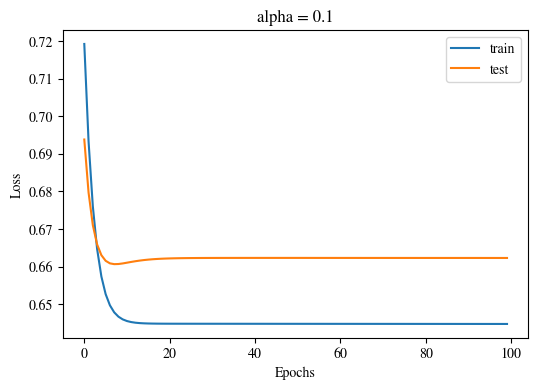

Epoch 0 | Train cost: 0.8872947428878923 | Test cost: 0.8696346218870262
Epoch 10 | Train cost: 0.7780440615504007 | Test cost: 0.7681609281059251
Epoch 20 | Train cost: 0.7086491313992548 | Test cost: 0.7049945990390395
Epoch 30 | Train cost: 0.6722959615086517 | Test cost: 0.6725587000781919
Epoch 40 | Train cost: 0.6559841278621406 | Test cost: 0.6582618559966197
Epoch 50 | Train cost: 0.6493785860998407 | Test cost: 0.6525774732259417
Epoch 60 | Train cost: 0.6468567032794265 | Test cost: 0.650474362605365
Epoch 70 | Train cost: 0.645916430826073 | Test cost: 0.6497408317742452
Epoch 80 | Train cost: 0.6455625527901527 | Test cost: 0.6495103267924698
Epoch 90 | Train cost: 0.6454220228120872 | Test cost: 0.6494572891259773


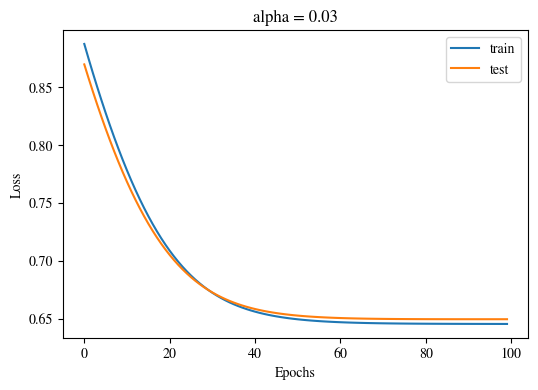

Epoch 0 | Train cost: 0.7003111956188453 | Test cost: 0.6884613521559502
Epoch 10 | Train cost: 0.649063286600612 | Test cost: 0.6548020653749916
Epoch 20 | Train cost: 0.645170152168158 | Test cost: 0.6536142434598519
Epoch 30 | Train cost: 0.6448328912809745 | Test cost: 0.6538353335202325
Epoch 40 | Train cost: 0.6447824309511908 | Test cost: 0.6539204428878688
Epoch 50 | Train cost: 0.6447520917525836 | Test cost: 0.6538921139454625
Epoch 60 | Train cost: 0.6447330096361015 | Test cost: 0.6538407155783589
Epoch 70 | Train cost: 0.6447133180795627 | Test cost: 0.6537601918928231
Epoch 80 | Train cost: 0.6446993701623042 | Test cost: 0.6537064640577271
Epoch 90 | Train cost: 0.6446874577841676 | Test cost: 0.6536493492443682


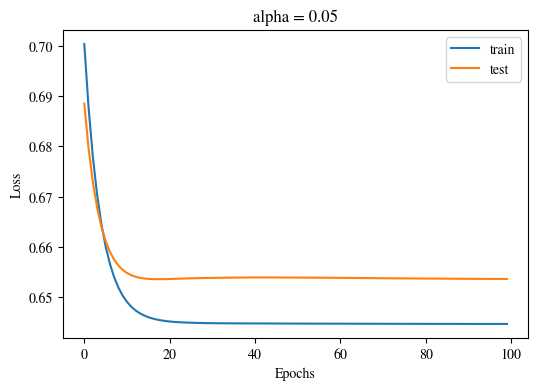

Epoch 0 | Train cost: 1.0068242227373276 | Test cost: 0.9790620040345323
Epoch 10 | Train cost: 0.8926712330016452 | Test cost: 0.8786538737381123
Epoch 20 | Train cost: 0.8541991132307891 | Test cost: 0.8429914215003995
Epoch 30 | Train cost: 0.8298020541568948 | Test cost: 0.8202963542841035
Epoch 40 | Train cost: 0.8113983379432793 | Test cost: 0.8026107973238239
Epoch 50 | Train cost: 0.796448405796307 | Test cost: 0.7884193115835753
Epoch 60 | Train cost: 0.7836771998065649 | Test cost: 0.7766492206669058
Epoch 70 | Train cost: 0.7722690257555406 | Test cost: 0.7662063965603731
Epoch 80 | Train cost: 0.7619898587810884 | Test cost: 0.7566736930198195
Epoch 90 | Train cost: 0.752612154367702 | Test cost: 0.7479608184764198


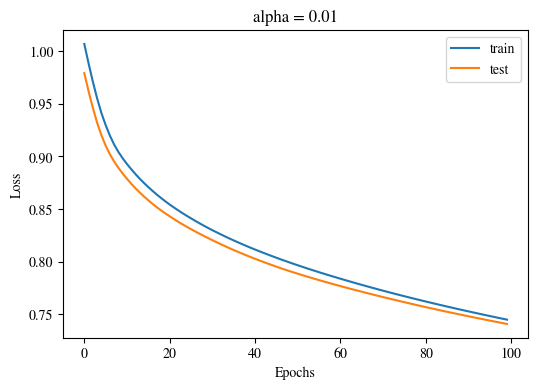

Epoch 0 | Train cost: 0.8232544937929197 | Test cost: 0.8172466944686348
Epoch 10 | Train cost: 0.8024686965183391 | Test cost: 0.7971294561400273
Epoch 20 | Train cost: 0.7839680308183463 | Test cost: 0.779271349351567
Epoch 30 | Train cost: 0.7675382726231478 | Test cost: 0.763457576922132
Epoch 40 | Train cost: 0.7529764308644724 | Test cost: 0.7494849166935038
Epoch 50 | Train cost: 0.7400924787065415 | Test cost: 0.7371633420183453
Epoch 60 | Train cost: 0.7287101867163481 | Test cost: 0.7263168135114804
Epoch 70 | Train cost: 0.7186674125107031 | Test cost: 0.7167836157350003
Epoch 80 | Train cost: 0.7098161444359598 | Test cost: 0.7084163178403693
Epoch 90 | Train cost: 0.7020221351577782 | Test cost: 0.7010813740342899


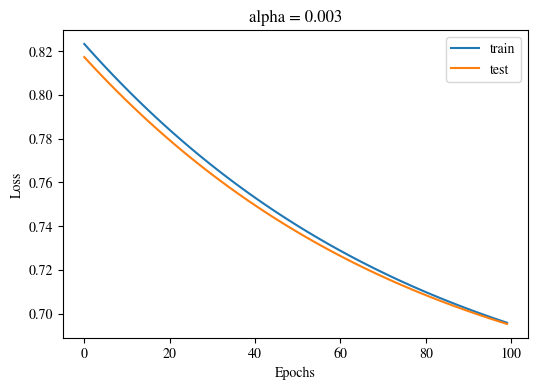

Epoch 0 | Train cost: 1.305573689613637 | Test cost: 1.2823735148473392
Epoch 10 | Train cost: 1.2489697613671535 | Test cost: 1.227351750753493
Epoch 20 | Train cost: 1.1964445190168156 | Test cost: 1.176324871314636
Epoch 30 | Train cost: 1.1477764022735804 | Test cost: 1.1290750031245498
Epoch 40 | Train cost: 1.1027504031074955 | Test cost: 1.0853917797228982
Epoch 50 | Train cost: 1.0611611956463924 | Test cost: 1.0450738704829938
Epoch 60 | Train cost: 1.0228115919980088 | Test cost: 1.0079274924906243
Epoch 70 | Train cost: 0.987511174924814 | Test cost: 0.9737659670570196
Epoch 80 | Train cost: 0.9550760239785445 | Test cost: 0.9424089460877736
Epoch 90 | Train cost: 0.9253285711547548 | Test cost: 0.9136806370456396


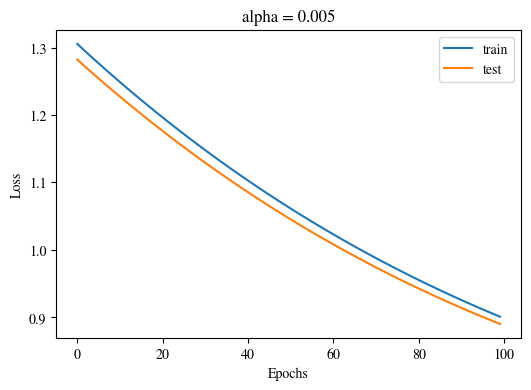

Epoch 0 | Train cost: 0.6818867875316982 | Test cost: 0.6937689179726025
Epoch 10 | Train cost: 0.6805673317907386 | Test cost: 0.6923820524947611
Epoch 20 | Train cost: 0.6792923466214507 | Test cost: 0.6910403788362454
Epoch 30 | Train cost: 0.6780603395437202 | Test cost: 0.6897424955375844
Epoch 40 | Train cost: 0.6768701519660107 | Test cost: 0.6884871446360213
Epoch 50 | Train cost: 0.6757204676000753 | Test cost: 0.6872730248279827
Epoch 60 | Train cost: 0.6746101521165506 | Test cost: 0.6860989285234852
Epoch 70 | Train cost: 0.6735377941129699 | Test cost: 0.6849635651467902
Epoch 80 | Train cost: 0.6725020481798385 | Test cost: 0.6838658320969734
Epoch 90 | Train cost: 0.6715016754760441 | Test cost: 0.682804728095287


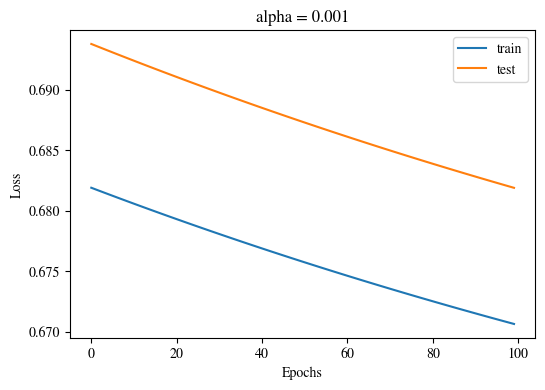

Epoch 0 | Train cost: 0.6994498199029339 | Test cost: 0.7199886078922847
Epoch 10 | Train cost: 0.6991731548300375 | Test cost: 0.7196712501117705
Epoch 20 | Train cost: 0.6988979276591193 | Test cost: 0.7193555050745426
Epoch 30 | Train cost: 0.698624045351981 | Test cost: 0.7190413371585388
Epoch 40 | Train cost: 0.6983516553554436 | Test cost: 0.7187288167623254
Epoch 50 | Train cost: 0.6980807488432488 | Test cost: 0.7184179342932552
Epoch 60 | Train cost: 0.6978113170465334 | Test cost: 0.7181086802207362
Epoch 70 | Train cost: 0.6975433512534223 | Test cost: 0.7178010450757898
Epoch 80 | Train cost: 0.6972768428086228 | Test cost: 0.7174950194506149
Epoch 90 | Train cost: 0.6970117831130244 | Test cost: 0.7171905939981544


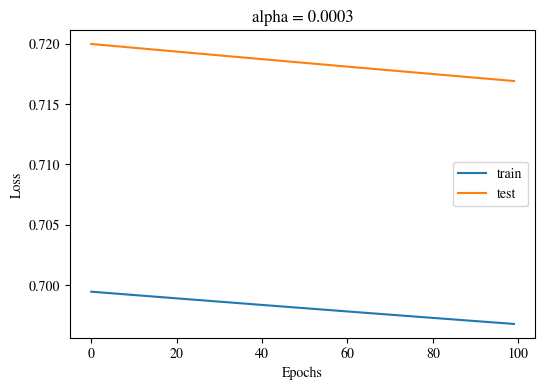

Epoch 0 | Train cost: 0.6481380038924252 | Test cost: 0.6570492642120835
Epoch 10 | Train cost: 0.6480526671468329 | Test cost: 0.6570121376766975
Epoch 20 | Train cost: 0.6479693434294798 | Test cost: 0.6569765044497631
Epoch 30 | Train cost: 0.6478879864752803 | Test cost: 0.6569423228693421
Epoch 40 | Train cost: 0.6478085980963624 | Test cost: 0.6569095573486959
Epoch 50 | Train cost: 0.6477312609692473 | Test cost: 0.6568781749599257
Epoch 60 | Train cost: 0.6476558396153453 | Test cost: 0.6568481269652519
Epoch 70 | Train cost: 0.6475822032633228 | Test cost: 0.6568193692575189
Epoch 80 | Train cost: 0.647510310671854 | Test cost: 0.6567918651024907
Epoch 90 | Train cost: 0.6474401215146424 | Test cost: 0.6567655786619422


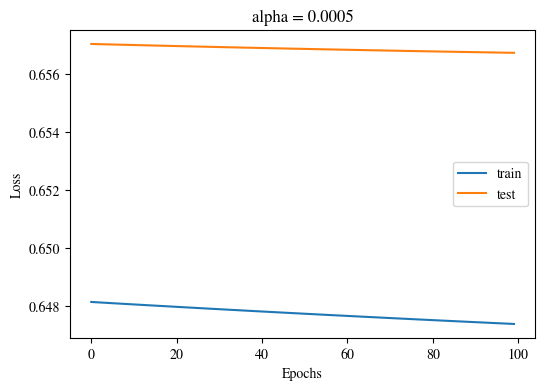

In [9]:
alpha_values = [0.1, 0.03, 0.05, 0.01, 0.003, 0.005, 0.001, 0.0003, 0.0005]
for alpha in alpha_values:
    train_costs, test_costs = train(
        X_train, y_train, X_test, y_test, parameters, alpha, epochs, layers
    )

    plt.figure(figsize=(6, 4))
    plt.plot(train_costs, label="train")
    plt.plot(test_costs, label="test")
    plt.legend()
    plt.title(f"alpha = {alpha}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()